In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Functions

In [2]:
def quick_boxplot(series,title,**kwargs):
    logscale = kwargs.get('logscale',True)
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(data=series,orient='h')
    plt.suptitle(title)
    if logscale:
        ax.set(xscale="log")
    plt.show()

In [3]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [4]:
def get_tukey(df,tukey_col):
    q75, q25 = np.percentile(df[tukey_col], [75 ,25])
    iqr = q75 - q25
    tukey_dict = {}
    for threshold in np.arange(1,5.5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
#        print("The score threshold is: {}".format(threshold))
        num_outliers = len((np.where((df[tukey_col] > max_val) | (df[tukey_col] < min_val))[0]))
#        print("Number of outliers is: {}".format(num_outliers))
        tukey_dict.update({threshold: [min_val, max_val, num_outliers]})
    return tukey_dict

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [5]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

### Data cleaning, feature building

In [6]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [7]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Performing a log transformation on lot area helps make this distribution look more normal. Let's run with that.

In [8]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

In [9]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})
house_df['has_centralair'] = (house_df['centralair'].map({'Y': 1, 'N': 0}))

In [10]:
# Start with these features of interest. 
vars_of_interest = ['saleprice','log_lotarea','neighborhood','bldgtype','housestyle','yearbuilt','fireplaces',
                    'grlivarea','garagearea','has_deck','has_porch','has_centralair']

house_interest_df = house_df[vars_of_interest]
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,fireplaces,grlivarea,garagearea,has_deck,has_porch,has_centralair
0,208500,9.041922,CollgCr,1Fam,2Story,2003,0,1710,548,0,1,1
1,181500,9.169518,Veenker,1Fam,1Story,1976,1,1262,460,1,0,1
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1,1786,608,0,1,1
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1,1717,642,0,1,1
4,250000,9.565214,NoRidge,1Fam,2Story,2000,1,2198,836,1,1,1


In [11]:
# Append one-hot versions of neighborhoods and house style to the dataframe of interesting variables
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['neighborhood'],drop_first=True)], axis=1)
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['housestyle'],drop_first=True)], axis=1)
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,fireplaces,grlivarea,garagearea,has_deck,has_porch,has_centralair,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
0,208500,9.041922,CollgCr,1Fam,2Story,2003,0,1710,548,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,181500,9.169518,Veenker,1Fam,1Story,1976,1,1262,460,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1,1786,608,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1,1717,642,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,250000,9.565214,NoRidge,1Fam,2Story,2000,1,2198,836,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [12]:
hidf_features = ['log_lotarea','yearbuilt','grlivarea','garagearea','has_porch', 
                  'Edwards','fireplaces','has_centralair',
                  'Mitchel','NAmes','NWAmes','NoRidge','NridgHt','Sawyer',
                  'SawyerW','StoneBr','1Story', #'1.5Unf','SFoyer','SLvl'
                  ]

## Reimplement your model from the previous checkpoint.

__NOTE:__ Performing a log transformation on the dependent variable (home sale price) made its distribution much more normal, and made the model fit better.

In [13]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice'])

# X is the feature set.
X = house_interest_df[hidf_features]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [15]:
# We add constant to the model as it's a best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     278.9
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:07:19   Log-Likelihood:                 375.81
No. Observations:                1168   AIC:                            -715.6
Df Residuals:                    1150   BIC:                            -624.5
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.3582      0.452      5.216      0.000       1.471       3.245
log_lotarea        0.1098      0.012      9.148      0.000       0.086       0.133
yearbuilt          0.0040      0.000     17.912      0.000       0.004       0.004
grlivarea          0.0003   1.51e-05     20.014      0.000       0.000       0.000
garagearea         0.0002   3.23e-05      7.082      0.000       0.000       0.000
has_porch          0.0594      0.012      4.930      0.000       0.036       0.083
Edwards           -0.1349      0.022     -6.062      0.000      -0.179      -0.091
fireplaces         0.0673      0.009      7.160      0.000       0.049       0.086
has_centralair     0.1982      0.024      8.373      0.000       0.152       0.245
Mitchel           -0.1018      0.031     -3.328      0.001      -0.162      -0.042
NAmes             -0.0506      0.016     -3.160      0.002      -0.082      -0.019
NWAmes            -0.0692      0.025     -2.807      0.005      -0.117      -0.021
NoRidge            0.1271      0.034      3.763      0.000       0.061       0.193
NridgHt            0.1814      0.025      7.275      0.000       0.132       0.230
Sawyer            -0.1029      0.025     -4.186      0.000      -0.151      -0.055
SawyerW           -0.0787      0.028     -2.809      0.005      -0.134      -0.024
StoneBr            0.2625      0.043      6.065      0.000       0.178       0.347
1Story             0.0457      0.013      3.654      0.000       0.021       0.070
==============================================================================
Omnibus:                      591.140   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11914.458
Skew:                          -1.864   Prob(JB):                         0.00
Kurtosis:                      18.196   Cond. No.                     2.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

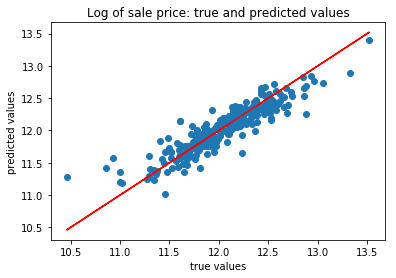

Mean absolute error of the prediction is: 0.11912847872322506
Mean squared error of the prediction is: 0.029084219104442293
Root mean squared error of the prediction is: 0.17054096019561485
Mean absolute percentage error of the prediction is: 0.993848409132504


In [16]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Log of sale price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Which model is the best? Why?

(OLS results are above. I didn't use k-fold cross-validation but I can if you really want...?)

In [17]:
def kfold_xval(model,train_data,target_data):
    print("Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:")
    cross_val_array = cross_val_score(model, train_data, target_data, cv=10)
    print(cross_val_array)

In [22]:
# I learned that the estimator object (first parameter) needs to be from the sklearn module--
# I can't use sm.OLS. :)
kfold_xval(LinearRegression(),X,Y)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.85075675 0.85708745 0.84161781 0.7601886  0.81506759 0.82993206
 0.80221185 0.812407   0.59025523 0.83399374]


I read up out of curiosity---by default, cross_val_score uses the $R^2$ stat for scoring--so unfortunately what we're seeing here is a range of scores from 59% - 86%, which means we're probably overfitting. The test run above has an $R^2$ value of around 80%.

So if we are overfitting, how do we fix that?

__Moving on for now, here is Ridge:__

I started with `alpha=10**1` and kept increasing the exponent, until the folds reported back numbers that are reasonably close to each other. Above and below `10**9`, one of the folds was consistently a lot lower than the others. Further tuning to `10.5**9` brought the $R^2$ values down, but also brought them to within 5% of each other.

In [108]:
from sklearn.linear_model import Ridge
kfold_xval(Ridge(alpha=10.5**9),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.13394467 0.18540723 0.16859182 0.15981076 0.1693453  0.16264321
 0.13773682 0.15672455 0.150738   0.13316366]


In [109]:
kfold_xval(Ridge(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.71892465 0.85031431 0.84308749 0.81944314 0.84356867 0.80257166
 0.60568149 0.84362723 0.80030455 0.82024401]


These $R^2$ values seem terrible, but the lesson material suggests this may be okay? How does this look with the full test set?

In [50]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**9) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.2353258326159975
-----Test set statistics-----
R-squared of the model on the test set is: 0.2402439295694199
Mean absolute error of the prediction is: 0.27261492894099276
Mean squared error of the prediction is: 0.12668771541344503
Root mean squared error of the prediction is: 0.35593217810903954
Mean absolute percentage error of the prediction is: 2.2686505847531975


__LASSO:__

Again, just manually increasing the exponent, `alpha=11**2` seems to offer consistent results across folds.

In [101]:
from sklearn.linear_model import Lasso
kfold_xval(Lasso(alpha=11**2),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.12444902 0.14665907 0.14034476 0.14524938 0.14611931 0.13687134
 0.13640442 0.1363817  0.15018645 0.12526164]


In [110]:
kfold_xval(Lasso(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.60059154 0.8122855  0.78622001 0.72286138 0.75521339 0.76357978
 0.40431533 0.77774418 0.72058753 0.72158945]


In [102]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
lassoregr = Lasso(alpha=11**2) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.2508668834811152
-----Test set statistics-----
R-squared of the model on the test set is: 0.25873144987397634
Mean absolute error of the prediction is: 0.29082969119307855
Mean squared error of the prediction is: 0.14220233067640484
Root mean squared error of the prediction is: 0.3770972429976184
Mean absolute percentage error of the prediction is: 2.4199132878166734


__ElasticNet:__

I played with values of alpha until I saw the scores become reasonably close, and ultimately stuck with `12**2`. For further tuning I tried different values for l1_ratio and finally decided upon `.8`, meaning `alpha1=12**2 * .8` and `alpha2=12**2 * (1 - .8)=12**2 * .2`

In [97]:
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import Lasso
kfold_xval(ElasticNet(alpha=12**2,l1_ratio=.8),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.14914526 0.18648919 0.17566589 0.17777758 0.18467608 0.17049243
 0.16380191 0.16633254 0.17710276 0.15026132]


In [111]:
kfold_xval(ElasticNet(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.60940747 0.80831257 0.78868217 0.73517569 0.76440422 0.76500513
 0.41677444 0.78632506 0.73089551 0.72098178]


In [98]:
elasticregr = ElasticNet(alpha=12**2, l1_ratio=.8) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.17583043713418312
-----Test set statistics-----
R-squared of the model on the test set is: 0.17987368085913602
Mean absolute error of the prediction is: 0.2843511584289848
Mean squared error of the prediction is: 0.13675432650838878
Root mean squared error of the prediction is: 0.36980309153438506
Mean absolute percentage error of the prediction is: 2.3661965564943137
